TEXT

Install Libraries

In [17]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

In [18]:
!pip cache purge
!pip install -U pip setuptools wheel

Files removed: 16 (3.5 MB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 115.8 kB/s eta 0:00:1

ERROR: To modify pip, please run the following command:
D:\Anaconda\python.exe -m pip install -U pip setuptools wheel


In [19]:
!pip install matplotlib --upgrade

Import libraries and Hyperparameter

In [20]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (
    set_seed,
    TrainingArguments,
    Trainer,
    GPT2Config,
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW


# Set seed for reproducibility.
set_seed(130)
# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 2

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 128

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 40

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'not_informative': 0, 'informative': 1}
# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)


create Train Dataset

In [21]:
class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    a=pd.read_csv('data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_alltask_informative_text_img_train.tsv')
    self.texts = []
    self.labels = []
   
    for content in a['tweet_text']:
       self.texts.append(content)
    # Since the labels are defined by folders with data we loop 
     # through each label.
    for label in a['label_text']:
       self.labels.append(label)
  
         # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.
          Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}


Create validation Dataset

In [22]:
class MovieReviewsDatasetvalid(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    a=pd.read_csv('data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv')
    self.texts = []
    self.labels = []
   
    for content in a['tweet_text']:
       self.texts.append(content)
    # Since the labels are defined by folders with data we loop 
     # through each label.
    for label in a['label_text']:
       self.labels.append(label)

         # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.
          Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}


Create Test Dataset

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MovieReviewsDataset(Dataset):
    def __init__(self, path, tokenizer, task='informative', split='train', max_length=128):
        # Construct TSV file path
        file_path = f"{path}/task_{task}_text_img_{split}.tsv"
        
        # Read TSV with tab separator, skip malformed lines
        df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')
        
        # Make sure to check the correct column names
        self.texts = df['text'].tolist()       # Replace 'text' if your column name is different
        self.labels = df['label'].tolist()     # Replace 'label' if your column name is different
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            "input_ids": encoding['input_ids'].squeeze(0),
            "attention_mask": encoding['attention_mask'].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)   # ✅ Convert label to tensor
        }


GPT2 Classifier

In [24]:
def gpt2_classification_collator(batch):
    input_ids = torch.stack([x['input_ids'] for x in batch])
    attention_mask = torch.stack([x['attention_mask'] for x in batch])
    labels = torch.stack([x['labels'] for x in batch])
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


Load GPT2 Classifier

In [25]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model_text = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model_text.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model_text.config.pad_token_id = model_text.config.eos_token_id

# Load model to defined device.
model_text.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Model loaded to `cpu`


Create batches for training,test and validation Data

In [26]:
import pandas as pd
import warnings
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore", category=DeprecationWarning)

# ==================== Dataset Class ====================
class MovieReviewsDataset(Dataset):
    def __init__(self, tsv_path, tokenizer):
        # Read TSV file safely
        df = pd.read_csv(tsv_path, sep='\t', on_bad_lines='skip')
        print(f"Loaded {tsv_path} with columns: {df.columns.tolist()}")

        # Automatically detect likely text and label columns
        text_col = None
        label_col = None
        for col in df.columns:
            if 'text' in col.lower():
                text_col = col
            if 'label' in col.lower() or 'damage' in col.lower() or 'humanitarian' in col.lower():
                label_col = col

        if text_col is None or label_col is None:
            raise ValueError("Could not automatically detect text/label columns in TSV file.")

        self.texts = df[text_col].tolist()
        self.labels = df[label_col].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {"input_ids": encoding['input_ids'].squeeze(0),
                "attention_mask": encoding['attention_mask'].squeeze(0),
                "labels": label}

# ==================== Paths ====================
base_path = 'data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/'
train_file = base_path + 'task_informative_text_img_train.tsv'
valid_file = base_path + 'task_informative_text_img_dev.tsv'
test_file  = base_path + 'task_informative_text_img_test.tsv'

# ==================== Dataloaders ====================
batch_size = 8  # adjust as needed

# Train
train_dataset = MovieReviewsDataset(train_file, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Train dataset: {len(train_dataset)} examples, {len(train_dataloader)} batches")

# Validation
valid_dataset = MovieReviewsDataset(valid_file, tokenizer)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print(f"Validation dataset: {len(valid_dataset)} examples, {len(valid_dataloader)} batches")

# Test
test_dataset = MovieReviewsDataset(test_file, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Test dataset: {len(test_dataset)} examples, {len(test_dataloader)} batches")


Loaded data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv with columns: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label', 'label_text', 'label_image', 'label_text_image']
Train dataset: 13608 examples, 1701 batches
Loaded data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv with columns: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label', 'label_text', 'label_image', 'label_text_image']
Validation dataset: 2237 examples, 280 batches
Loaded data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv with columns: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label', 'label_text', 'label_image', 'label_text_image']
Test dataset: 2237 examples, 280 batches


Train data

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class MovieReviewsDataset(Dataset):
    def __init__(self, path, tokenizer, task='informative', split='train', max_length=128):
        # Construct TSV file path
        file_path = f"{path}/task_{task}_text_img_{split}.tsv"
        
        # Read TSV with tab separator, skip malformed lines
        df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')
        
        # Make sure to check the correct column names
        self.texts = df['text'].tolist()       # Replace 'text' if your column name is different
        self.labels = df['label'].tolist()     # Replace 'label' if your column name is different
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            "input_ids": encoding['input_ids'].squeeze(0),
            "attention_mask": encoding['attention_mask'].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)   # ✅ Convert label to tensor
        }


In [28]:
def gpt2_classification_collator(batch):
    input_ids = torch.stack([x['input_ids'] for x in batch])
    attention_mask = torch.stack([x['attention_mask'] for x in batch])
    labels = torch.stack([x['labels'] for x in batch])
    
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


In [29]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class MovieReviewsDataset(Dataset):
    def __init__(self, path, tokenizer, split='train', max_length=128):
        file_map = {
            'train': 'task_informative_text_img_train.tsv',
            'dev': 'task_informative_text_img_dev.tsv',
            'test': 'task_informative_text_img_test.tsv'
        }
        file_path = f"{path}/{file_map[split]}"
        df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')

        self.texts = df['tweet_text'].tolist()
        # Map string labels to integers
        label_map = {'informative': 1, 'not_informative': 0}  
        self.labels = df['label'].map(label_map).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]  # now it's an integer

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Flatten tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)  # must be long for classification
        return item


# === Hyperparameters ===
batch_size = 16
max_length = 128

# Assume `tokenizer` is already defined
gpt2_classification_collator = lambda batch: {
    key: torch.stack([b[key] for b in batch]) for key in batch[0]
}

# === Create datasets & dataloaders ===
path = 'data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all'

train_dataset = MovieReviewsDataset(path=path, tokenizer=tokenizer, split='train', max_length=max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classification_collator)

valid_dataset = MovieReviewsDataset(path=path, tokenizer=tokenizer, split='dev', max_length=max_length)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classification_collator)

test_dataset = MovieReviewsDataset(path=path, tokenizer=tokenizer, split='test', max_length=max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classification_collator)

print(f"Train batches: {len(train_dataloader)}, Validation batches: {len(valid_dataloader)}, Test batches: {len(test_dataloader)}")


Train batches: 851, Validation batches: 140, Test batches: 140


In [49]:
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # ---------- TRAIN ----------
    model_text.train()
    train_labels, train_preds = [], []
    train_loss_total = 0
    
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_text(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss_total += loss.item()
        train_labels += labels.cpu().numpy().tolist()
        train_preds += logits.argmax(dim=1).cpu().numpy().tolist()
    
    train_acc = accuracy_score(train_labels, train_preds)
    train_loss_avg = train_loss_total / len(train_dataloader)

    # ---------- VALIDATION ----------
    model_text.eval()
    val_labels, val_preds = [], []
    val_loss_total = 0

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model_text(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss_total += loss.item()
            val_labels += labels.cpu().numpy().tolist()
            val_preds += logits.argmax(dim=1).cpu().numpy().tolist()

    val_acc = accuracy_score(val_labels, val_preds)
    val_loss_avg = val_loss_total / len(valid_dataloader)

    print(f"Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    all_loss['train_loss'].append(train_loss_avg)
    all_loss['val_loss'].append(val_loss_avg)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)



Epoch 1/2


100%|██████████| 851/851 [1:31:33<00:00,  6.46s/it]


Train Loss: 0.5326, Val Loss: 0.5802, Train Acc: 0.7396, Val Acc: 0.7287

Epoch 2/2


100%|██████████| 851/851 [1:47:50<00:00,  7.60s/it]


Train Loss: 0.5355, Val Loss: 0.5802, Train Acc: 0.7376, Val Acc: 0.7287


In [69]:
from sklearn.metrics import classification_report, confusion_matrix

# ---------- TEST EVALUATION ----------
model_text.eval()
test_labels, test_preds = [], []

with torch.no_grad():
    for batch in test_dataloader:  # ensure this exists
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_text(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        test_labels += labels.cpu().numpy().tolist()
        test_preds += logits.argmax(dim=1).cpu().numpy().tolist()

# ---------- REPORT ----------
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['not_informative', 'informative']))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, test_preds))



Classification Report:
                 precision    recall  f1-score   support

not_informative       0.82      0.36      0.50       864
    informative       0.70      0.95      0.81      1373

       accuracy                           0.72      2237
      macro avg       0.76      0.65      0.65      2237
   weighted avg       0.75      0.72      0.69      2237


Confusion Matrix:
[[ 308  556]
 [  66 1307]]


In [74]:
print(f"Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

all_loss['train_loss'].append(train_loss_avg)
all_loss['val_loss'].append(val_loss_avg)
all_acc['train_acc'].append(train_acc)
all_acc['val_acc'].append(val_acc)

Train Loss: 0.5355, Val Loss: 0.5802, Train Acc: 0.7376, Val Acc: 0.7287


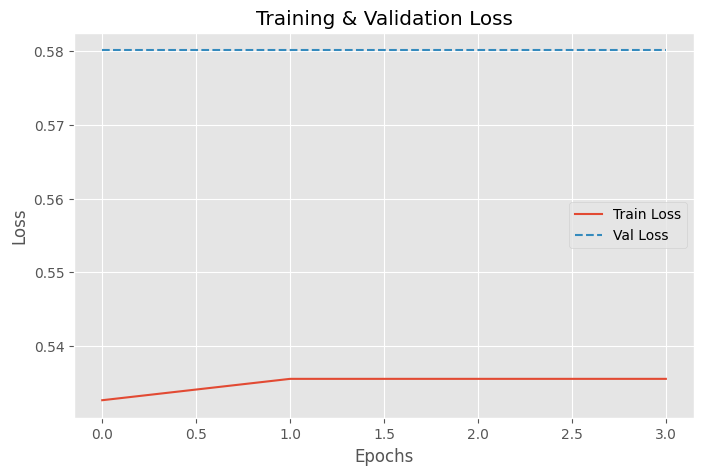

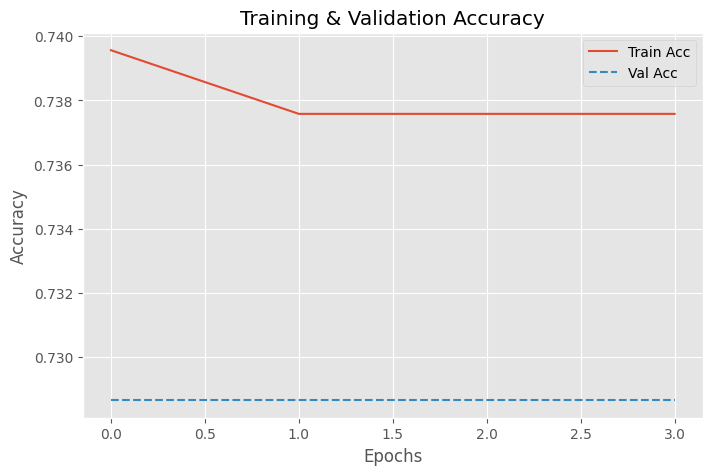

In [70]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(all_loss['train_loss'], label='Train Loss', linestyle='-')
plt.plot(all_loss['val_loss'], label='Val Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(all_acc['train_acc'], label='Train Acc', linestyle='-')
plt.plot(all_acc['val_acc'], label='Val Acc', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()


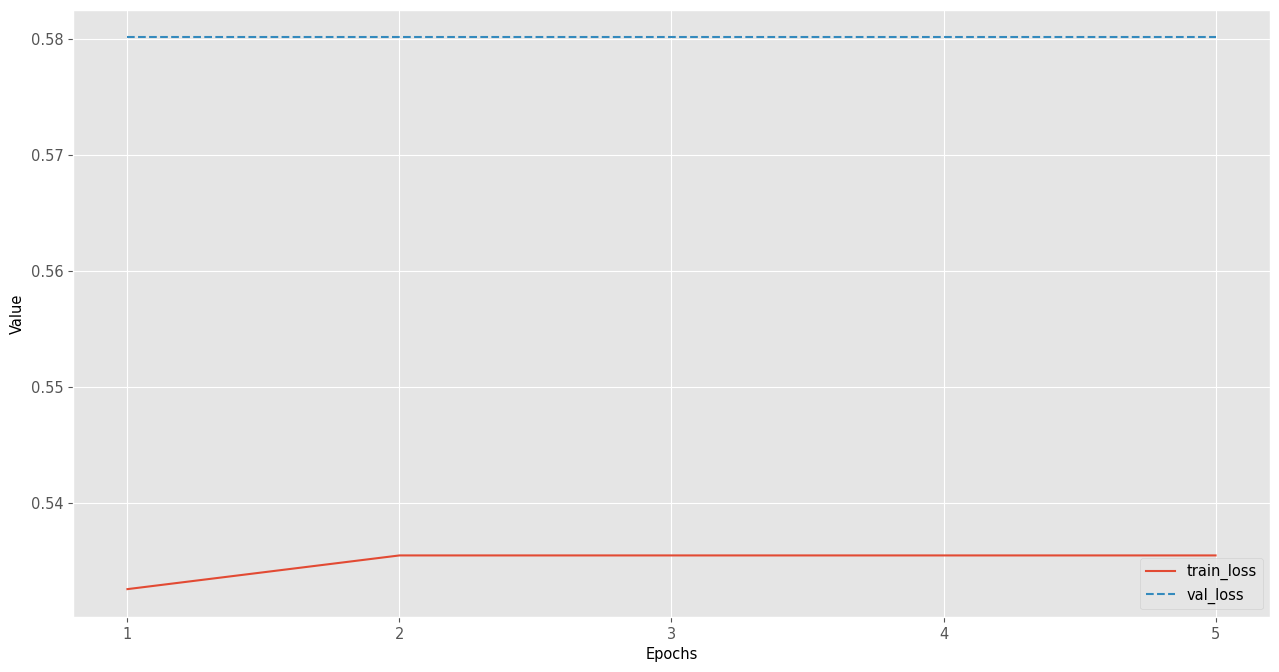

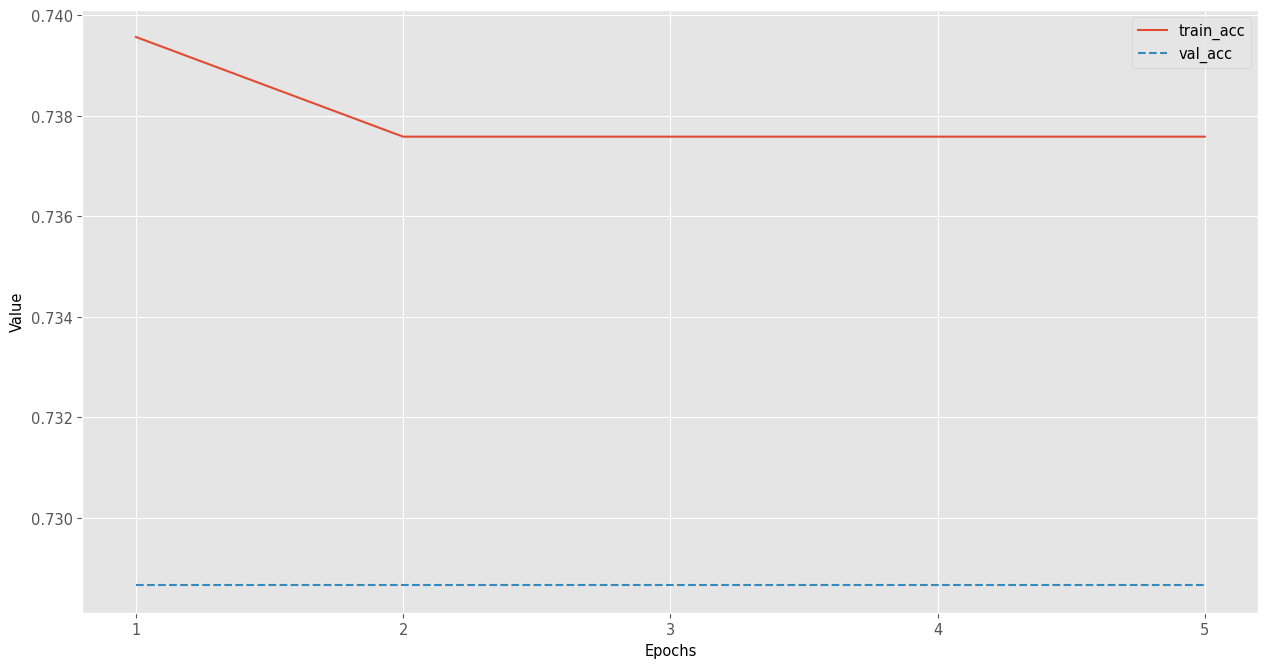

In [75]:
# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

Save model

In [76]:
import joblib
joblib.dump(model_text, 'textmodelGPT2.pkl')

['textmodelGPT2.pkl']

Load Model

In [34]:
# Load the model from the file
text_from_joblib = joblib.load('textmodelGPT2.pkl')


Plot trainig and Validation Loss

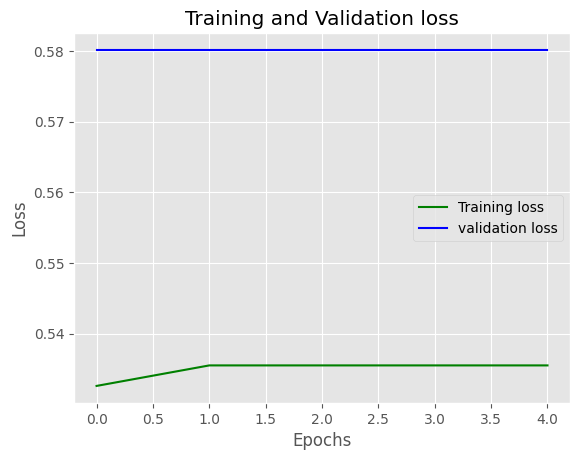

In [77]:
import matplotlib.pyplot as plt
plt.plot(all_loss['train_loss'], 'g', label='Training loss')
plt.plot(all_loss['val_loss'], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_loss_val_loss_text_gpt2',dpi=400)
plt.show()

Plot training and validation accuracy

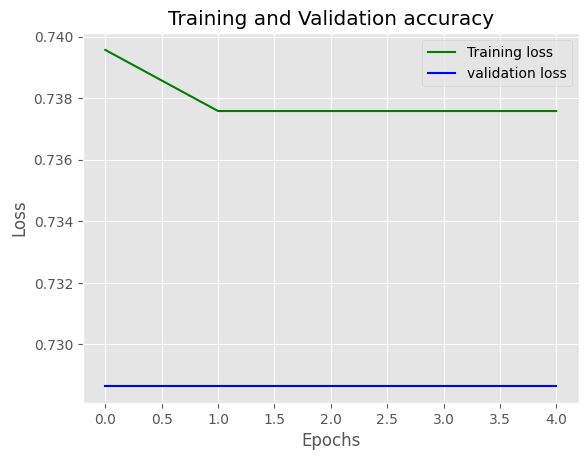

In [78]:
import matplotlib.pyplot as plt
plt.plot(all_acc['train_acc'], 'g', label='Training loss')
plt.plot(all_acc['val_acc'], 'b', label='validation loss')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_acc_val_acc_text_gpt2',dpi=400)
plt.show()

Print classification report

In [79]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, test_preds, target_names=['not_informative', 'informative']))


                 precision    recall  f1-score   support

not_informative       0.82      0.36      0.50       864
    informative       0.70      0.95      0.81      1373

       accuracy                           0.72      2237
      macro avg       0.76      0.65      0.65      2237
   weighted avg       0.75      0.72      0.69      2237



Print and Plot confusion matrix

In [81]:
print(confusion_matrix(test_labels, test_preds))


[[ 308  556]
 [  66 1307]]


In [82]:
cf_matrix=confusion_matrix(test_labels, test_preds)

<Axes: >

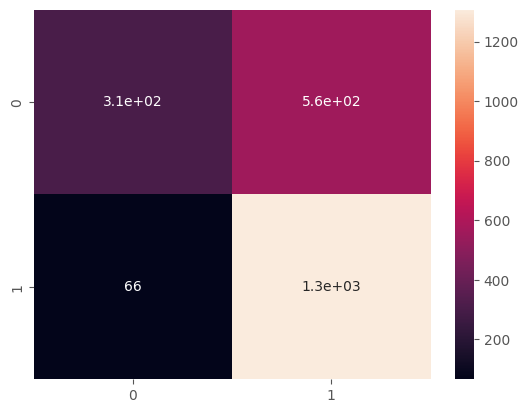

In [83]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

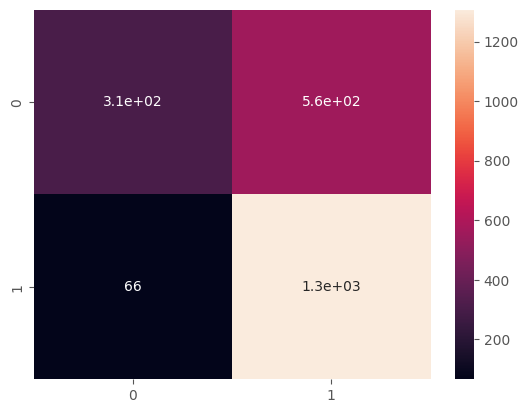

In [84]:
figure_cm=sns.heatmap(cf_matrix, annot=True)

In [85]:
figure_cm.figure.savefig('confusionmatrix_text_2epoch.png')

Plot ROC curve

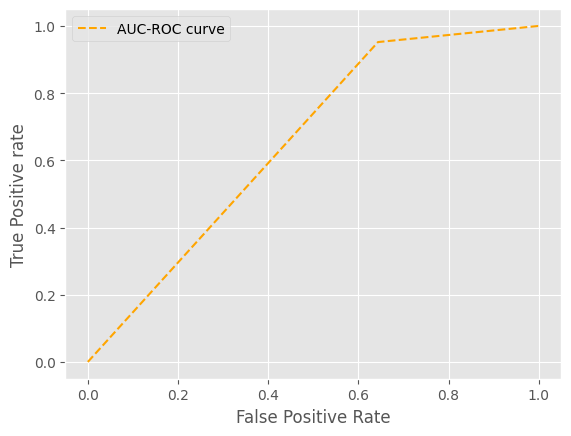

In [87]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, test_preds, pos_label=1)
plt.plot(fpr1, tpr1, linestyle='--',color='orange',label='AUC-ROC curve')
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC_text',dpi=300)
plt.show();


Roc Curve

In [88]:
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(test_labels,test_preds)
print( auc_score1)

0.6542057807990074


In [89]:
all_loss

{'train_loss': [0.5325859618383064,
  0.5354904769170158,
  0.5354904769170158,
  0.5354904769170158,
  0.5354904769170158],
 'val_loss': [0.5801543729645865,
  0.5801543729645865,
  0.5801543729645865,
  0.5801543729645865,
  0.5801543729645865]}

Train and validation Loss

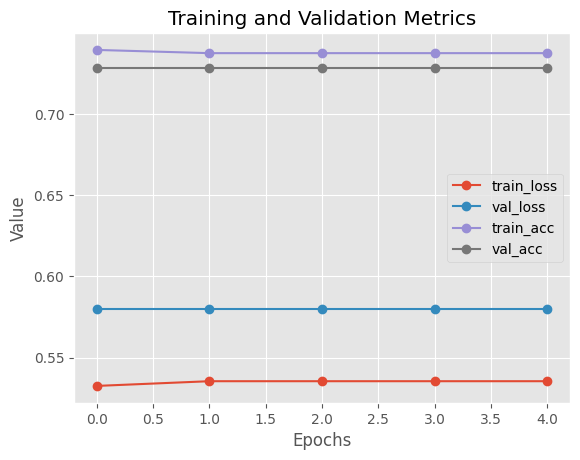

In [92]:
history_df = pd.DataFrame({**all_loss, **all_acc})
history_df.plot(title="Training and Validation Metrics", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()
